In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc

pd.set_option('max_columns', 300)

In [12]:
def make_scores(data):
    to_keep = ['made1', 'made2', 'made3', 'miss1', 'miss2', 'miss3', 'reb', 'turnover', 'assist', 'steal', 'block']
    df = data[data.EventType.isin(to_keep)].copy()
    to_drop = ['EventPlayerID', 'EventSubType', 'X', 'Y', 'Area']
    df.drop(to_drop, axis=1, inplace=True)
    
    df['tourney'] = np.where(df.DayNum >= 132, 1, 0)
    
    df['points_made'] = 0
    df.loc[df.EventType == 'made1', 'points_made'] = 1
    df.loc[df.EventType == 'made2', 'points_made'] = 2
    df.loc[df.EventType == 'made3', 'points_made'] = 3
    df['tmp_gameID'] = df['DayNum'].astype(str) + '_' + df['WTeamID'].astype(str) + '_' + df['LTeamID'].astype(str)
    df['Final_difference'] = df['WFinalScore'] - df['LFinalScore']
    
    df = df.sort_values(by=['DayNum', 'WTeamID', 'ElapsedSeconds'])
    
    df['points'] = df.groupby(['tmp_gameID', 'EventTeamID']).points_made.cumsum() - df.points_made
    
    del df['WCurrentScore']
    del df['LCurrentScore']
    
    df.loc[df.WTeamID == df.EventTeamID, 'WCurrentScore'] = df.points
    df.loc[df.LTeamID == df.EventTeamID, 'LCurrentScore'] = df.points

    df['WCurrentScore'] = df.groupby('tmp_gameID')['WCurrentScore'].fillna(method='ffill').fillna(0)
    df['LCurrentScore'] = df.groupby('tmp_gameID')['LCurrentScore'].fillna(method='ffill').fillna(0)
    
    df['Current_difference'] = df['WCurrentScore'] - df['LCurrentScore']
    
    del df['points']
    del df['points_made']
    del df['tmp_gameID']
    
    return df


def quarter_score(data):
    df = data.copy()
    
    df['period'] = 1
    df.loc[df.ElapsedSeconds >= 20 * 60, 'period'] = 2
    df.loc[df.ElapsedSeconds >= 40 * 60, 'period'] = 3
    
    df['crunch'] = 0
    df.loc[(df.ElapsedSeconds > 37 * 60) & (df.ElapsedSeconds <= 40 * 60), 'crunch'] = 1
    
    df['minutes'] = df['ElapsedSeconds'] / 60
    df['tmp_gameID'] = df['DayNum'].astype(str) + '_' + df['WTeamID'].astype(str) + '_' + df['LTeamID'].astype(str)
    
    ot = ((df.groupby('tmp_gameID').minutes.max() - 40) / 5).reset_index()
    ot['n_OT'] = np.where(ot.minutes > 0, np.ceil(ot.minutes), 0)    
    half = df[df.period==1].groupby(['tmp_gameID'], as_index=False)[['WCurrentScore', 'LCurrentScore']].max()
    half['Halftime_difference'] = half['WCurrentScore'] - half['LCurrentScore']
    half.drop(['WCurrentScore', 'LCurrentScore'], axis=1, inplace=True)
    crunchtime = df[df.crunch==0].groupby(['tmp_gameID'], as_index=False)[['WCurrentScore', 'LCurrentScore']].max()
    crunchtime['3mins_difference'] = crunchtime['WCurrentScore'] - crunchtime['LCurrentScore']
    crunchtime.drop(['WCurrentScore', 'LCurrentScore'], axis=1, inplace=True)
    
    add_ons = pd.merge(ot[['tmp_gameID', 'n_OT']], half, on='tmp_gameID')
    add_ons = pd.merge(add_ons, crunchtime, on='tmp_gameID')
    
    df = pd.merge(df, add_ons, on='tmp_gameID')
    
    del df['tmp_gameID']
    del df['minutes']
    
    if data.shape[0] != df.shape[0]:
        raise KeyError('Some merge went wrong')
    
    return df


def lead_changes(data):
    df = data.copy()
    df['tmp_gameID'] = df['DayNum'].astype(str) + '_' + df['WTeamID'].astype(str) + '_' + df['LTeamID'].astype(str)
    
    changes = df.groupby('tmp_gameID').Current_difference.apply(lambda x: len(np.where(np.diff(np.sign(x)))[0])).reset_index()
    changes.rename(columns={'Current_difference': 'game_lc'}, inplace=True)
    changes_2 = df[df.period==2].groupby('tmp_gameID').Current_difference.apply(lambda x: len(np.where(np.diff(np.sign(x)))[0])).reset_index()
    changes_2.rename(columns={'Current_difference': 'half2_lc'}, inplace=True)
    changes_3 = df[df.crunch==1].groupby('tmp_gameID').Current_difference.apply(lambda x: len(np.where(np.diff(np.sign(x)))[0])).reset_index()
    changes_3.rename(columns={'Current_difference': 'crunchtime_lc'}, inplace=True)
    
    add_ons = pd.merge(changes, changes_2, on='tmp_gameID')
    add_ons = pd.merge(add_ons, changes_3, on='tmp_gameID', how='left')
    
    df = pd.merge(df, add_ons, on='tmp_gameID', how='left').fillna(0)
    
    del df['tmp_gameID']
    
    if data.shape[0] != df.shape[0]:
        raise KeyError('Some merge went wrong')
        
    return df


def _scoreinblock(data, text):
    
    df = data.groupby('tmp_gameID', as_index=False)[['WFinalScore', 'LFinalScore', 'WCurrentScore', 'LCurrentScore']].min()
    df[f'Wpoints_made_{text}'] = df['WFinalScore'] - df['WCurrentScore']
    df[f'Lpoints_made_{text}'] = df['LFinalScore'] - df['LCurrentScore']
    
    return df[['tmp_gameID', f'Wpoints_made_{text}', f'Lpoints_made_{text}']]


def _statcount(data, stat, text):
    
    tmp = data.copy()
    tmp['is_stat'] = np.where(tmp.EventType==stat, 1, 0)
    tmp = tmp.groupby(['tmp_gameID', 'EventTeamID'], as_index=False).is_stat.sum()
    
    return tmp.rename(columns={'is_stat': text})


def event_count(data):
    df = data.copy()
    df['tmp_gameID'] = df['DayNum'].astype(str) + '_' + df['WTeamID'].astype(str) + '_' + df['LTeamID'].astype(str)
    
    # points made in each block
    half2 = _scoreinblock(df[df.period==2], 'half2')
    crunch = _scoreinblock(df[df.crunch==1], 'crunchtime')
    
    add_ons = pd.merge(half2, crunch, on='tmp_gameID')
    add_ons = pd.merge(add_ons, df[['tmp_gameID', 'WTeamID', 'LTeamID']].drop_duplicates(), on='tmp_gameID')
    
    # stats in each block
    stats = ['made1', 'made2', 'made3', 'miss1', 'miss2', 'miss3', 'reb', 'turnover', 'assist', 'steal', 'block']
    
    period = 'game'    
    for stat in stats:
        name = f'{stat}_{period}'
        to_merge = _statcount(df, stat, name)
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'WTeamID', 
                                                   name: f'W{name}'}), on=['tmp_gameID', 'WTeamID'])
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'LTeamID', 
                                                   name: f'L{name}'}), on=['tmp_gameID', 'LTeamID'])
        gc.collect()
        
    period = 'half2'
    tmp = df[df.period==2]
    for stat in stats:
        name = f'{stat}_{period}'
        to_merge = _statcount(tmp, stat, name)
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'WTeamID', 
                                                   name: f'W{name}'}), on=['tmp_gameID', 'WTeamID'])
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'LTeamID', 
                                                   name: f'L{name}'}), on=['tmp_gameID', 'LTeamID'])
        gc.collect()
        
    period = 'crunchtime'
    tmp = df[df.crunch==1]
    for stat in stats:
        name = f'{stat}_{period}'
        to_merge = _statcount(tmp, stat, name)
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'WTeamID', 
                                                   name: f'W{name}'}), on=['tmp_gameID', 'WTeamID'])
        add_ons = pd.merge(add_ons, to_merge.rename(columns={'EventTeamID': 'LTeamID', 
                                                   name: f'L{name}'}), on=['tmp_gameID', 'LTeamID'])
        gc.collect()
    
    for period in ['game', 'half2', 'crunchtime']:
        # % of scores with assists
        add_ons[f'WAst_perc_{period}'] = (add_ons[f'Wassist_{period}'] / (add_ons[f'Wmade2_{period}'] + add_ons[f'Wmade3_{period}'])).fillna(0)
        add_ons[f'LAst_perc_{period}'] = (add_ons[f'Lassist_{period}'] / (add_ons[f'Lmade2_{period}'] + add_ons[f'Lmade3_{period}'])).fillna(0)
        # % scores
        add_ons[f'WFGM_perc_{period}'] = ((add_ons[f'Wmade2_{period}'] + add_ons[f'Wmade3_{period}'])
                                          / (add_ons[f'Wmade2_{period}'] + add_ons[f'Wmade3_{period}'] + 
                                             add_ons[f'Wmiss2_{period}'] + add_ons[f'Wmiss3_{period}'])).fillna(0)
        add_ons[f'LFGM_perc_{period}'] = ((add_ons[f'Lmade2_{period}'] + add_ons[f'Lmade3_{period}'])
                                          / ((add_ons[f'Lmade2_{period}'] + add_ons[f'Lmade3_{period}']) + 
                                             add_ons[f'Lmiss2_{period}'] + add_ons[f'Lmiss3_{period}'])).fillna(0)
        add_ons[f'WFGM3_perc_{period}'] = (add_ons[f'Wmade3_{period}'] / (add_ons[f'Wmade3_{period}'] + add_ons[f'Wmiss3_{period}'])).fillna(0)
        add_ons[f'LFGM3_perc_{period}'] = (add_ons[f'Lmade3_{period}'] / (add_ons[f'Lmade3_{period}'] + add_ons[f'Lmiss3_{period}'])).fillna(0)
        add_ons[f'WFTM_perc_{period}'] = (add_ons[f'Wmade1_{period}'] / (add_ons[f'Wmade1_{period}'] + add_ons[f'Wmiss1_{period}'])).fillna(0)
        add_ons[f'LFTM_perc_{period}'] = (add_ons[f'Lmade1_{period}'] / (add_ons[f'Lmade1_{period}'] + add_ons[f'Lmiss1_{period}'])).fillna(0)
        
    
    unique_cols = ['Season', 'DayNum', 'tourney', 'tmp_gameID', 'WTeamID', 'LTeamID', 
                   'WFinalScore', 'LFinalScore', 'Final_difference', 'n_OT', 
                   'Halftime_difference', '3mins_difference', 
                   'game_lc', 'half2_lc', 'crunchtime_lc']
    
    to_drop = ['WTeamID', 'LTeamID'] + [col for col in add_ons if 'miss' in col]
    
    df = pd.merge(df[unique_cols].drop_duplicates(), add_ons.drop(to_drop, axis=1), on='tmp_gameID')
    
    del df['tmp_gameID']
    
    return df

In [3]:
df_2020 = pd.read_csv('data/raw_men/MEvents2020.csv')

df_2020 = make_scores(df_2020)
df_2020 = quarter_score(df_2020)
df_2020 = lead_changes(df_2020)
df_2020 = event_count(df_2020)

df_2020.head()

,Season,DayNum,tourney,WTeamID,LTeamID,WFinalScore,LFinalScore,Final_difference,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_game,Lmade1_game,Wmade2_game,Lmade2_game,Wmade3_game,Lmade3_game,Wreb_game,Lreb_game,Wturnover_game,Lturnover_game,Wassist_game,Lassist_game,Wsteal_game,Lsteal_game,Wblock_game,Lblock_game,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_game,LAst_perc_game,WFGM_perc_game,LFGM_perc_game,WFGM3_perc_game,LFGM3_perc_game,WFTM_perc_game,LFTM_perc_game,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime
0,2020,1,0,1114,1283,67,66,1,0.0,-6.0,-1.0,16,3,3,34.0,27.0,4.0,2.0,10,12,24,15,3,8,36,31,13,10,17,10,7,7,3,3,5,5,13,5,1,4,19,11,6,7,8,3,4,4,1,0,0,2,2,0,0,0,4,1,1,1,1,0,0,1,0,0,0.629630,0.434783,0.519231,0.425926,0.214286,0.285714,0.666667,0.666667,0.571429,0.333333,0.538462,0.375000,0.125000,0.333333,0.833333,0.714286,0.50,0.0,0.500000,0.000000,0.0,0.0,0.000,1.0
1,2020,1,0,1116,1349,91,43,48,0.0,20.0,48.0,4,0,0,52.0,24.0,6.0,6.0,7,9,27,14,10,2,48,31,21,27,19,7,14,9,5,2,4,8,15,8,6,0,24,18,12,15,11,5,11,7,3,1,0,2,3,2,0,0,3,3,1,1,0,1,1,1,0,0,0.513514,0.437500,0.552239,0.285714,0.400000,0.080000,0.636364,0.600000,0.523810,0.625000,0.617647,0.258065,0.461538,0.000000,0.571429,0.727273,0.00,0.5,0.600000,0.666667,0.0,0.0,0.000,0.5
2,2020,1,0,1120,1204,83,74,9,0.0,4.0,12.0,24,0,0,42.0,37.0,9.0,10.0,18,15,22,22,7,5,44,28,21,18,13,8,6,10,2,2,15,7,12,9,1,4,23,15,8,10,4,4,1,5,1,0,5,4,1,3,0,0,5,3,0,1,0,0,0,0,0,0,0.448276,0.296296,0.500000,0.473684,0.318182,0.277778,0.720000,0.714286,0.307692,0.307692,0.464286,0.464286,0.111111,0.444444,0.789474,0.636364,0.00,0.0,0.333333,0.600000,0.0,0.0,0.625,0.8
3,2020,1,0,1124,1146,105,61,44,0.0,21.0,34.0,1,0,0,52.0,29.0,10.0,0.0,7,13,22,18,18,4,53,35,14,15,25,11,6,5,2,6,1,3,12,10,9,2,28,17,7,8,14,6,4,2,1,2,0,0,2,0,2,0,7,4,0,2,3,0,1,0,1,0,0.625000,0.500000,0.563380,0.360656,0.545455,0.173913,0.500000,0.541667,0.666667,0.500000,0.552632,0.363636,0.500000,0.153846,0.200000,0.500000,0.75,0.0,0.500000,0.000000,0.4,0.0,0.000,0.0
4,2020,1,0,1135,1136,73,71,2,0.0,1.0,0.0,30,21,8,39.0,38.0,6.0,4.0,22,13,18,17,5,8,44,40,15,12,9,14,7,9,2,0,13,5,10,9,2,5,20,18,5,5,4,7,3,2,0,0,3,2,1,1,0,0,4,4,0,1,0,0,1,0,0,0,0.391304,0.560000,0.433962,0.403226,0.294118,0.285714,0.709677,0.619048,0.333333,0.500000,0.480000,0.451613,0.285714,0.333333,0.764706,0.555556,0.00,0.0,0.333333,0.250000,0.0,0.0,0.750,0.5


In [3]:
all_events_m = []

for year in np.arange(2015, 2021):
    print(year)
    df = pd.read_csv(f'data/raw_men/MEvents{year}.csv')
    df = make_scores(df)
    df = quarter_score(df)
    df = lead_changes(df)
    df = event_count(df)
    all_events_m.append(df)
    gc.collect()

all_events_m = pd.concat(all_events_m, ignore_index=True)

all_events_m.head()

2015
2016
2017
2018
2019
2020


,Season,DayNum,tourney,WTeamID,LTeamID,WFinalScore,LFinalScore,Final_difference,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_game,Lmade1_game,Wmade2_game,Lmade2_game,Wmade3_game,Lmade3_game,Wreb_game,Lreb_game,Wturnover_game,Lturnover_game,Wassist_game,Lassist_game,Wsteal_game,Lsteal_game,Wblock_game,Lblock_game,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_game,LAst_perc_game,WFGM_perc_game,LFGM_perc_game,WFGM3_perc_game,LFGM3_perc_game,WFTM_perc_game,LFTM_perc_game,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime
0,2015,11,0,1103,1420,74,57,17,0.0,11.0,24.0,12.0,0.0,0.0,37.0,31.0,3.0,11.0,12,14,13,17,12,3,39,40,12,16,17,13,7,9,5,0,5,12,4,8,8,1,22,23,7,6,9,7,2,7,4,0,1,4,1,2,0,1,1,7,1,1,0,2,0,1,1,0,0.680000,0.650000,0.471698,0.416667,0.400000,0.250000,0.571429,0.500000,0.750000,0.777778,0.480000,0.391304,0.500000,0.333333,0.416667,0.521739,0.000000,0.666667,0.200000,0.75,0.000000,1.0,0.500000,0.666667
1,2015,11,0,1104,1406,82,54,28,0.0,12.0,30.0,4.0,0.0,0.0,43.0,24.0,5.0,7.0,17,11,22,11,7,7,36,36,8,22,17,9,14,2,9,2,8,7,13,7,3,1,19,19,4,12,9,3,8,1,6,1,2,2,0,2,1,0,5,3,1,0,1,0,0,1,0,1,0.586207,0.500000,0.460317,0.360000,0.304348,0.333333,0.894737,0.733333,0.562500,0.375000,0.484848,0.296296,0.300000,0.083333,0.888889,0.875000,1.000000,0.000000,0.166667,0.40,0.500000,0.0,1.000000,1.000000
2,2015,11,0,1112,1291,78,55,23,0.0,15.0,25.0,3.0,0.0,0.0,38.0,30.0,2.0,4.0,12,8,27,13,4,7,40,32,8,16,17,8,11,2,5,0,6,5,13,8,2,3,14,16,2,7,9,4,4,0,1,0,2,0,0,2,0,0,2,4,0,1,0,0,1,0,0,0,0.548387,0.400000,0.574074,0.384615,0.250000,0.333333,0.480000,0.666667,0.600000,0.363636,0.600000,0.458333,0.250000,0.375000,0.545455,0.714286,0.000000,0.000000,0.000000,0.50,0.000000,0.0,0.400000,0.000000
3,2015,11,0,1113,1152,86,50,36,0.0,12.0,32.0,6.0,0.0,0.0,46.0,22.0,8.0,4.0,19,13,23,14,7,3,44,36,11,17,17,7,7,5,4,3,14,7,13,6,2,1,29,27,4,11,7,2,6,3,3,2,1,4,2,0,1,0,7,7,0,1,1,0,1,0,0,0,0.566667,0.411765,0.612245,0.320755,0.437500,0.150000,0.558824,0.565217,0.466667,0.285714,0.555556,0.225806,0.333333,0.100000,0.560000,0.437500,0.333333,0.000000,0.500000,0.00,0.333333,0.0,0.166667,0.500000
4,2015,11,0,1119,1102,84,78,6,0.0,10.0,9.0,3.0,0.0,0.0,36.0,40.0,7.0,10.0,11,10,17,25,13,6,41,32,15,18,18,14,6,8,4,6,7,5,7,13,5,3,20,17,10,11,7,6,4,6,2,4,5,0,1,3,0,1,1,6,1,2,1,1,0,1,1,0,0.600000,0.451613,0.491803,0.500000,0.520000,0.315789,0.647059,0.666667,0.583333,0.375000,0.444444,0.500000,0.555556,0.300000,0.700000,0.625000,1.000000,0.250000,0.500000,0.50,0.000000,0.5,0.833333,0.000000


In [4]:
all_events_m.groupby(['Season', 'tourney'], as_index=False)[['Final_difference', 'Halftime_difference', '3mins_difference',
                                                           'n_OT', 'game_lc', 'half2_lc', 'crunchtime_lc']].agg(['max', 'mean', 'std'])

Final_difference                      Halftime_difference  \
                            max       mean       std                 max   
Season tourney                                                             
2015   0                     69  11.670491  9.017735                43.0   
       1                     41   9.402685  7.372263                26.0   
2016   0                     73  11.999058  9.181806                50.0   
       1                     44  11.591837  8.652148                32.0   
2017   0                     69  12.031891  9.370223                41.0   
       1                     39  11.117241  7.707773                25.0   
2018   0                     69  12.164343  9.405365                49.0   
       1                     44  10.992701  8.099107                28.0   
2019   0                     69  12.103999  9.300484                57.0   
       1                     38  10.696552  7.467824                36.0   
2020   0                     94  11.947260  9.123768                52.0   

                                   3mins_difference                        \
                    mean       std              max       mean        std   
Season tourney                                                              
2015   0        6.047959  8.437759             62.0  10.912733   9.745516   
       1        4.590604  7.713636             42.0   8.563758   8.915006   
2016   0        6.405956  8.525037             69.0  11.307388   9.936458   
       1        6.000000  8.613465             48.0  10.605442   9.829755   
2017   0        6.213913  8.655370             63.0  11.370944   9.969597   
       1        5.793103  7.664761             39.0   9.979310   8.413340   
2018   0        6.561443  8.802072             69.0  11.441718  10.109244   
       1        4.948905  7.285482             44.0  10.489051   8.970636   
2019   0        6.203962  8.810248             69.0  11.377109   9.972689   
       1        5.179310  8.327222             40.0   9.800000   8.593926   
2020   0        6.337462  8.544182             89.0  11.232170   9.840990   

               n_OT                     game_lc                      half2_lc  \
                max      mean       std     max       mean       std      max   
Season tourney                                                                  
2015   0        4.0  0.079556  0.328410    71.0  10.584540  8.317162     28.0   
       1        1.0  0.053691  0.226168    46.0  11.865772  8.388907     25.0   
2016   0        4.0  0.078213  0.333643    61.0  11.092348  8.709737     33.0   
       1        2.0  0.102041  0.365174    43.0  11.891156  9.081917     25.0   
2017   0        4.0  0.075532  0.322741    57.0  11.073294  8.680748     31.0   
       1        1.0  0.013793  0.117036    35.0  10.917241  8.225556     23.0   
2018   0        4.0  0.078825  0.322279    60.0  11.069158  8.686669     30.0   
       1        4.0  0.518248  0.900181    39.0  11.445255  8.518941     22.0   
2019   0        3.0  0.070616  0.297304    53.0  10.955613  8.489812     30.0   
       1        3.0  0.103448  0.367502    40.0  12.427586  8.662455     21.0   
2020   0        4.0  0.067755  0.304691    56.0  10.629129  8.322453     31.0   

                                   crunchtime_lc                      
                    mean       std           max      mean       std  
Season tourney                                                        
2015   0        3.452135  5.051970          10.0  0.564980  1.356283  
       1        4.194631  5.194433           7.0  0.657718  1.393866  
2016   0        3.618168  5.211826          13.0  0.604410  1.441584  
       1        4.292517  5.755534           7.0  0.591837  1.383638  
2017   0        3.587467  5.167435          11.0  0.586908  1.408398  
       1        3.751724  5.235471           7.0  0.586207  1.407254  
2018   0        3.635062  5.300326          12.0  0.612196  1.457023  
       1        3.408759  

In [5]:
all_events_w = []

for year in np.arange(2015, 2021):
    print(year)
    df = pd.read_csv(f'data/raw_women/WEvents{year}.csv')
    df = make_scores(df)
    df = quarter_score(df)
    df = lead_changes(df)
    df = event_count(df)
    all_events_w.append(df)
    gc.collect()

all_events_w = pd.concat(all_events_w, ignore_index=True)

all_events_w.head()

2015
2016
2017
2018
2019
2020


,Season,DayNum,tourney,WTeamID,LTeamID,WFinalScore,LFinalScore,Final_difference,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_game,Lmade1_game,Wmade2_game,Lmade2_game,Wmade3_game,Lmade3_game,Wreb_game,Lreb_game,Wturnover_game,Lturnover_game,Wassist_game,Lassist_game,Wsteal_game,Lsteal_game,Wblock_game,Lblock_game,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_game,LAst_perc_game,WFGM_perc_game,LFGM_perc_game,WFGM3_perc_game,LFGM3_perc_game,WFTM_perc_game,LFTM_perc_game,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime
0,2015,11,0,3103,3127,80,49,31,0.0,3.0,23.0,6.0,0.0,0.0,50.0,22.0,9.0,1.0,7,8,32,10,3,7,54,35,8,17,12,10,9,6,5,1,4,4,20,6,2,2,24,13,5,10,6,5,7,3,3,0,1,1,3,0,0,0,3,3,1,1,1,0,1,0,1,0,0.342857,0.588235,0.437500,0.333333,0.200000,0.318182,0.700000,0.533333,0.272727,0.625000,0.611111,0.363636,0.500000,0.200000,0.666667,0.363636,0.333333,0.0,1.000000,0.000000,0.0,0.0,1.000000,0.25
1,2015,11,0,3104,3197,60,44,16,0.0,12.0,13.0,2.0,0.0,0.0,30.0,26.0,7.0,4.0,15,3,21,13,1,5,62,45,19,24,9,11,15,11,7,7,11,2,8,9,1,2,31,23,9,10,4,8,8,5,6,4,2,0,2,2,0,0,4,4,2,3,2,2,3,1,3,1,0.409091,0.611111,0.360656,0.272727,0.076923,0.217391,0.441176,1.000000,0.444444,0.727273,0.310345,0.305556,0.125000,0.200000,0.550000,1.000000,1.000000,1.0,0.400000,0.285714,0.0,0.0,1.000000,0.00
2,2015,11,0,3107,3383,90,47,43,0.0,19.0,36.0,1.0,0.0,0.0,47.0,25.0,10.0,3.0,15,13,27,8,7,6,44,19,15,15,18,8,8,6,2,2,11,4,12,6,4,3,23,9,7,7,9,5,4,3,2,1,4,0,0,0,2,1,7,0,1,2,2,1,2,0,0,1,0.529412,0.571429,0.618182,0.325581,0.700000,0.300000,0.681818,0.684211,0.562500,0.555556,0.640000,0.409091,1.000000,0.428571,0.687500,0.444444,1.000000,1.0,0.500000,0.250000,1.0,0.5,0.666667,0.00
3,2015,11,0,3113,3292,81,67,14,0.0,12.0,17.0,1.0,0.0,0.0,44.0,40.0,6.0,9.0,28,16,22,21,3,3,48,46,10,17,15,12,10,6,8,3,22,13,10,9,0,3,29,29,5,8,5,8,5,5,7,2,4,4,1,2,0,0,4,4,1,0,1,1,0,1,1,0,0.600000,0.500000,0.390625,0.380952,0.187500,0.200000,0.756757,0.695652,0.500000,0.666667,0.333333,0.342857,0.000000,0.375000,0.709677,0.684211,1.000000,0.5,0.200000,0.333333,0.0,0.0,1.000000,1.00
4,2015,11,0,3114,3261,70,54,16,0.0,-2.0,20.0,26.0,8.0,0.0,46.0,28.0,2.0,6.0,23,25,16,13,5,1,38,39,13,20,9,3,7,4,2,0,16,14,9,7,4,0,19,20,5,9,5,0,3,1,2,0,0,0,1,3,0,0,2,5,1,1,0,0,0,0,1,0,0.428571,0.214286,0.428571,0.325581,0.357143,0.250000,0.676471,0.735294,0.384615,0.000000,0.541667,0.304348,0.571429,0.000000,0.727273,0.700000,0.000000,0.0,0.333333,0.500000,0.0,0.0,0.000000,0.00


In [6]:
all_events_w.groupby(['Season', 'tourney'], as_index=False)[['Final_difference', 'Halftime_difference', '3mins_difference',
                                                           'n_OT', 'game_lc', 'half2_lc', 'crunchtime_lc']].agg(['max', 'mean', 'std'])

Final_difference                       Halftime_difference  \
                            max       mean        std                 max   
Season tourney                                                              
2015   0                     75  14.010807  10.685186                46.0   
       1                     56  14.911765  12.448983                33.0   
2016   0                     76  14.381934  10.930488                30.0   
       1                     60  17.602941  13.673310                37.0   
2017   0                    108  14.628886  11.154059                33.0   
       1                     89  18.225352  16.496058                29.0   
2018   0                     81  14.820562  11.289110                32.0   
       1                     88  18.728571  14.058801                36.0   
2019   0                     72  14.706794  11.111185                33.0   
       1                     57  16.308824  13.086688                27.0   
2020   0                     81  14.363531  11.167070                51.0   

                                   3mins_difference                        \
                    mean       std              max       mean        std   
Season tourney                                                              
2015   0        7.319954  9.080305             72.0  13.101119  11.138362   
       1        7.000000  9.080075             58.0  13.838235  13.157610   
2016   0        3.774268  6.652729             76.0  14.469376  11.042964   
       1        5.955882  7.946526             62.0  17.705882  13.771113   
2017   0        3.989380  6.898906            108.0  14.727940  11.299221   
       1        5.436620  8.003093             89.0  18.197183  16.581073   
2018   0        4.135734  6.804289             81.0  14.905660  11.417145   
       1        5.828571  8.714425             88.0  19.257143  14.044119   
2019   0        4.008804  6.809984             75.0  14.821818  11.307811   
       1        6.000000  7.507210             57.0  16.500000  13.166556   
2020   0        7.406891  9.275484             79.0  13.544328  11.557000   

               n_OT                     game_lc                      half2_lc  \
                max      mean       std     max       mean       std      max   
Season tourney                                                                  
2015   0        4.0  0.143960  0.662009    51.0   9.237939  7.585371     32.0   
       1        3.0  0.088235  0.510642    33.0  11.014706  7.729557     16.0   
2016   0        5.0  4.000000  0.019629    44.0   9.031202  7.330161     18.0   
       1        4.0  4.000000  0.000000    26.0   7.838235  6.648107     12.0   
2017   0        4.0  3.999807  0.013896    50.0   9.111798  7.380204     17.0   
       1        4.0  4.000000  0.000000    33.0   8.408451  7.554710     11.0   
2018   0        4.0  4.000000  0.000000    46.0   8.850212  7.429876     18.0   
       1        4.0  4.000000  0.000000    30.0   9.200000  7.538500     18.0   
2019   0        4.0  4.000000  0.000000    44.0   8.965550  7.281842     17.0   
       1        4.0  4.000000  0.000000    33.0  10.191176  8.949706     10.0   
2020   0        3.0  0.054781  0.257133    49.0   9.372435  7.654285     32.0   

                                   crunchtime_lc                      
                    mean       std           max      mean       std  
Season tourney                                                        
2015   0        2.798919  4.559467          14.0  0.447897  1.217944  
       1        2.955882  4.375760           4.0  0.455882  0.999012  
2016   0        1.864599  2.854387           8.0  0.525616  1.215278  
       1        1.338235  2.572009           3.0  0.264706  0.725190  
2017   0        1.892064  2.891853           9.0  0.533887  1.211571  
       1        1.859155  2.899733           5.0  0.450704  1.204619  
2018   0        1.810166  2.836070          11.0  0.495572  1.202283  
       1    

# Competitive games

In [7]:
def make_competitive(data):
    df = data.copy()
    
    fil = ((df.Final_difference < 5) | (df['3mins_difference'] < 5) | (df.n_OT > 0) | 
     (df.game_lc > 20) | (df.half2_lc > 10) | (df.crunchtime_lc > 5))
    
    df['competitive'] = np.where(fil, 1, 0)
    
    return df

In [8]:
test = make_competitive(all_events_m)

test.groupby(['Season', 'tourney'], as_index=False).competitive.agg(['mean', 'sum'])

mean   sum
Season tourney                
2015   0        0.400978  2132
       1        0.476510    71
2016   0        0.393705  2089
       1        0.408163    60
2017   0        0.386982  2075
       1        0.413793    60
2018   0        0.393568  2117
       1        0.605839    83
2019   0        0.388665  2119
       1        0.462069    67
2020   0        0.378191  2015

In [9]:
test.groupby(['Season', 'tourney'], as_index=False).size()

Season  tourney
2015    0          5317
        1           149
2016    0          5306
        1           147
2017    0          5362
        1           145
2018    0          5379
        1           137
2019    0          5452
        1           145
2020    0          5328
dtype: int64

In [10]:
test = make_competitive(all_events_w)

test.groupby(['Season', 'tourney'], as_index=False).competitive.agg(['mean', 'sum'])

mean   sum
Season tourney                
2015   0        0.315515  1635
       1        0.308824    21
2016   0        1.000000  5192
       1        1.000000    68
2017   0        1.000000  5179
       1        1.000000    71
2018   0        1.000000  5194
       1        1.000000    70
2019   0        1.000000  5225
       1        1.000000    68
2020   0        0.311847  1611

In [11]:
test.groupby(['Season', 'tourney'], as_index=False).size()

Season  tourney
2015    0          5182
        1            68
2016    0          5192
        1            68
2017    0          5179
        1            71
2018    0          5194
        1            70
2019    0          5225
        1            68
2020    0          5166
dtype: int64

In [55]:
df_2020 = pd.read_csv('data/raw_men/MEvents2020.csv')

df_2020 = make_scores(df_2020)
df_2020 = quarter_score(df_2020)
df_2020 = lead_changes(df_2020)
df_2020 = make_competitive(df_2020)

df_2020 = df_2020[df_2020.EventType != 'assist']

df_2020.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,ElapsedSeconds,EventTeamID,EventType,tourney,Final_difference,WCurrentScore,LCurrentScore,Current_difference,period,crunch,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,competitive
0,13154596,2020,1,1114,1283,67,66,17,1114,turnover,0,1,0.0,0.0,0.0,1,0,0.0,-6.0,-1.0,16,3,3,1
1,13154597,2020,1,1114,1283,67,66,32,1283,made2,0,1,0.0,0.0,0.0,1,0,0.0,-6.0,-1.0,16,3,3,1
3,13154599,2020,1,1114,1283,67,66,53,1114,made2,0,1,0.0,2.0,-2.0,1,0,0.0,-6.0,-1.0,16,3,3,1
5,13154601,2020,1,1114,1283,67,66,85,1283,made3,0,1,2.0,2.0,0.0,1,0,0.0,-6.0,-1.0,16,3,3,1
7,13154603,2020,1,1114,1283,67,66,110,1114,miss2,0,1,2.0,5.0,-3.0,1,0,0.0,-6.0,-1.0,16,3,3,1


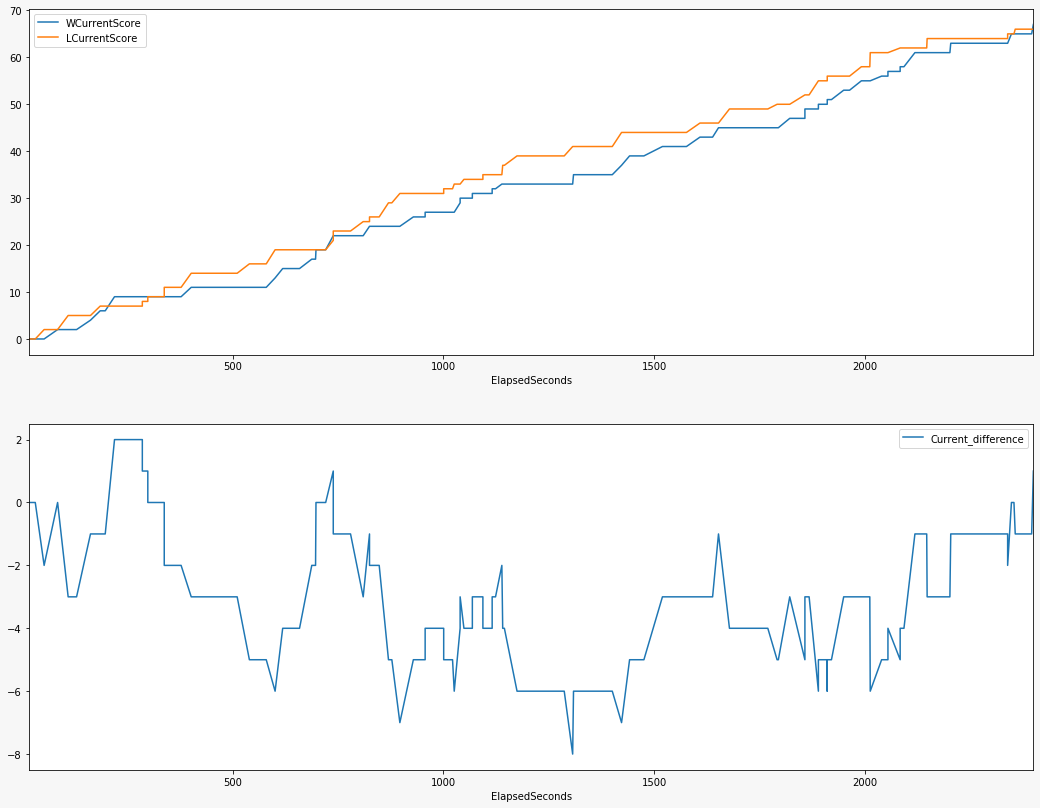

In [56]:
fig, ax = plt.subplots(2,1,figsize=(18,14), facecolor='#f7f7f7')

df_2020[(df_2020.WTeamID == 1114) & (df_2020.LTeamID == 1283)].plot(x='ElapsedSeconds', y='WCurrentScore', ax=ax[0])
df_2020[(df_2020.WTeamID == 1114) & (df_2020.LTeamID == 1283)].plot(x='ElapsedSeconds', y='LCurrentScore', ax=ax[0])
df_2020[(df_2020.WTeamID == 1114) & (df_2020.LTeamID == 1283)].plot(x='ElapsedSeconds', y='Current_difference', ax=ax[1])

plt.show()

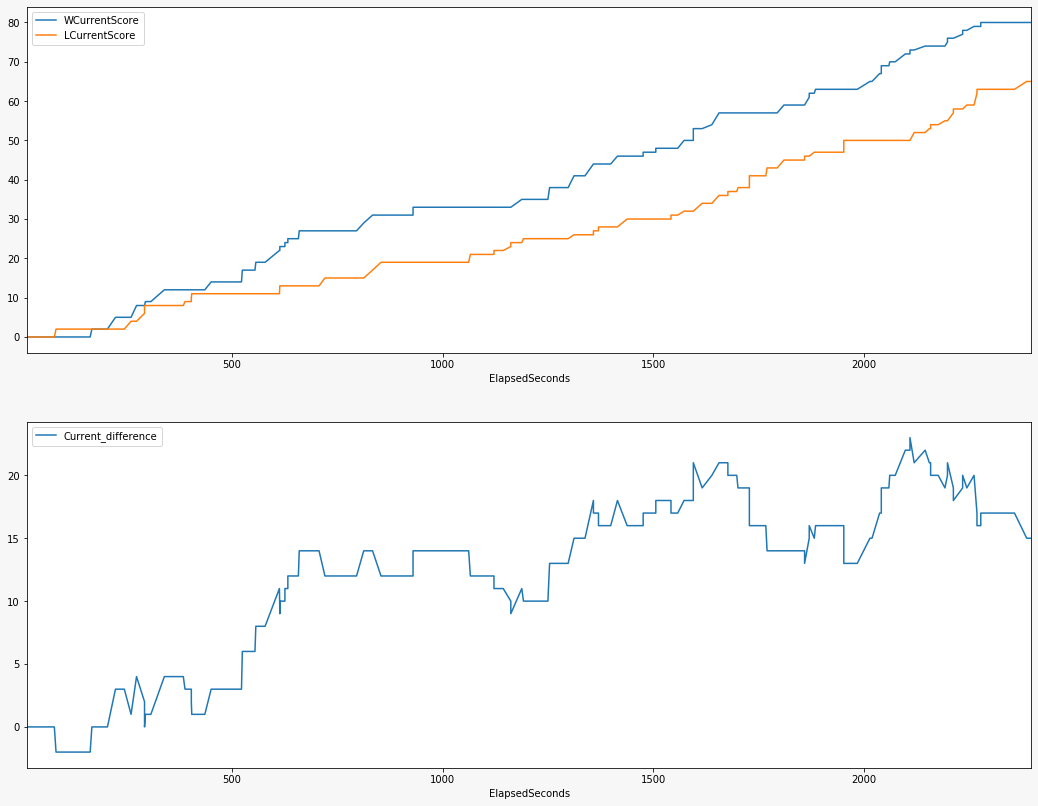

In [57]:
fig, ax = plt.subplots(2,1,figsize=(18,14), facecolor='#f7f7f7')

df_2020[(df_2020.WTeamID == 1450) & (df_2020.LTeamID == 1160)].plot(x='ElapsedSeconds', y='WCurrentScore', ax=ax[0])
df_2020[(df_2020.WTeamID == 1450) & (df_2020.LTeamID == 1160)].plot(x='ElapsedSeconds', y='LCurrentScore', ax=ax[0])
df_2020[(df_2020.WTeamID == 1450) & (df_2020.LTeamID == 1160)].plot(x='ElapsedSeconds', y='Current_difference', ax=ax[1])

plt.show()

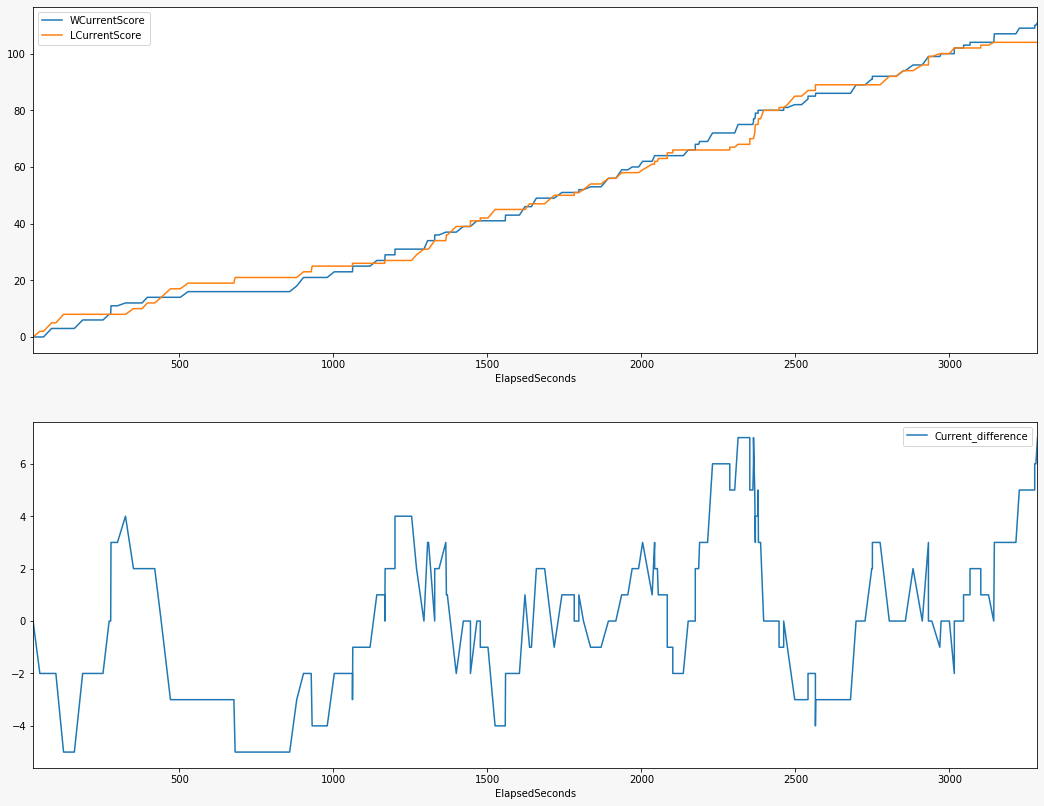

In [58]:
fig, ax = plt.subplots(2,1,figsize=(18,14), facecolor='#f7f7f7')

df_2020[df_2020.game_lc == df_2020.game_lc.max()].plot(x='ElapsedSeconds', y='WCurrentScore', ax=ax[0])
df_2020[df_2020.game_lc == df_2020.game_lc.max()].plot(x='ElapsedSeconds', y='LCurrentScore', ax=ax[0])
df_2020[df_2020.game_lc == df_2020.game_lc.max()].plot(x='ElapsedSeconds', y='Current_difference', ax=ax[1])

plt.show()

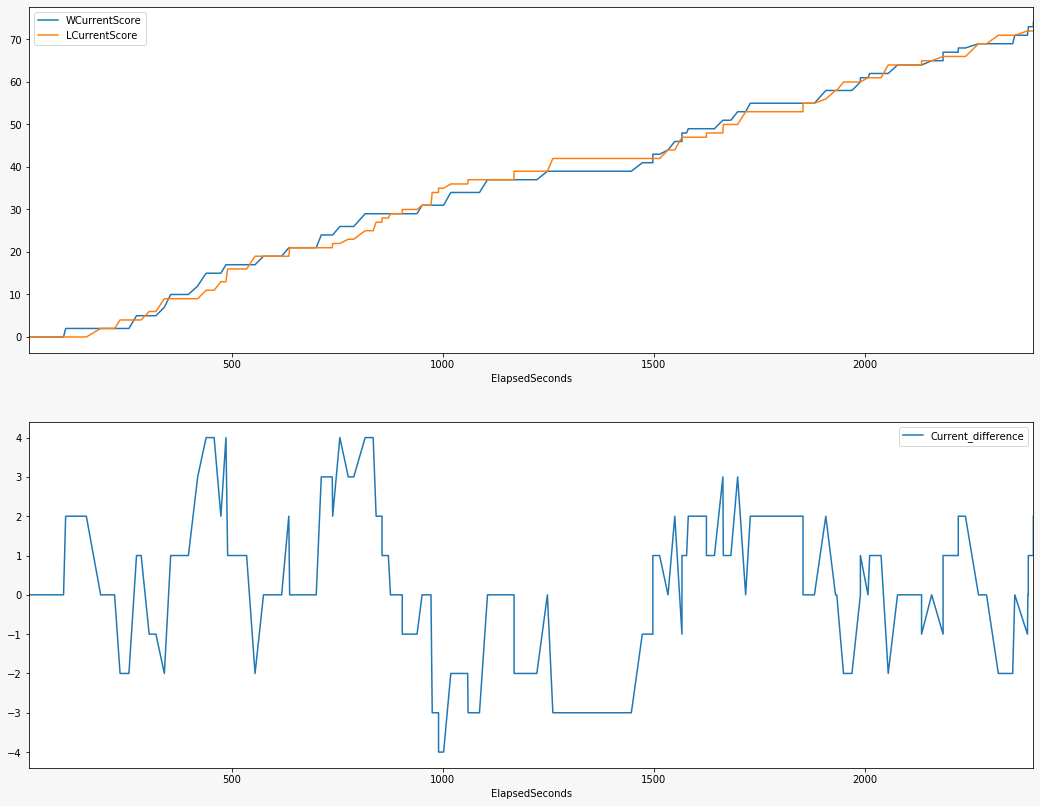

In [60]:
fig, ax = plt.subplots(2,1,figsize=(18,14), facecolor='#f7f7f7')

df_2020[df_2020.half2_lc == df_2020.half2_lc.max()].plot(x='ElapsedSeconds', y='WCurrentScore', ax=ax[0])
df_2020[df_2020.half2_lc == df_2020.half2_lc.max()].plot(x='ElapsedSeconds', y='LCurrentScore', ax=ax[0])
df_2020[df_2020.half2_lc == df_2020.half2_lc.max()].plot(x='ElapsedSeconds', y='Current_difference', ax=ax[1])

plt.show()

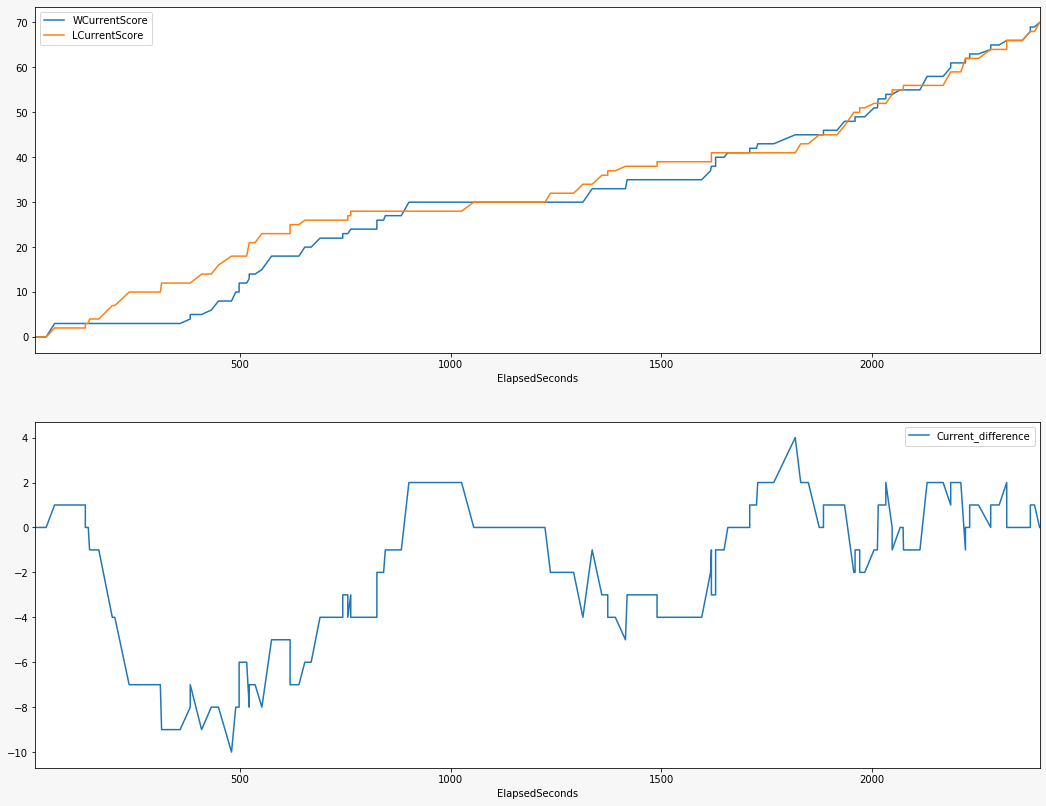

In [61]:
fig, ax = plt.subplots(2,1,figsize=(18,14), facecolor='#f7f7f7')

df_2020[df_2020.crunchtime_lc == df_2020.crunchtime_lc.max()].plot(x='ElapsedSeconds', y='WCurrentScore', ax=ax[0])
df_2020[df_2020.crunchtime_lc == df_2020.crunchtime_lc.max()].plot(x='ElapsedSeconds', y='LCurrentScore', ax=ax[0])
df_2020[df_2020.crunchtime_lc == df_2020.crunchtime_lc.max()].plot(x='ElapsedSeconds', y='Current_difference', ax=ax[1])

plt.show()